In [ ]:
!pip install arff
# !pip install optuna

  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4950 sha256=8c5976dca0257c32287879367e63072362487a240d78d1f5d46567731eb09b11
  Stored in directory: /root/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff


General Machine Learning Workflow:


1.   Problem Definition (Given)
2.   Data Collection (Given)
3.   Data Cleaning (Skipped)
4.   Metric Selection (Tweedie Loss, MSE, MAE, R-sqaure)
5.   Data Cding
6.   Algorithhm Selection (NN)
7.   Hyper pararmeter Tunning (Optuna, skipped)
8.   Model Selection (skipped)





**Load Dataset**

In [ ]:
import seaborn as sns
import pandas as pd
import arff
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_tweedie_deviance
import matplotlib.pyplot as plt


# Set random seed for reproducibility
random_seed = 35
torch.manual_seed(random_seed)
np.random.seed(random_seed)


# Load data
data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge", "DrivAge", "BonusMalus",
                                "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])
del data_freq, data_sev


# Hyper-parameters
feature_visualization = True
show_evaluation_plot = True
input_standardization = True
output_standardization = True
include_sampling_weights = True
tweedie_loss = True

if tweedie_loss:
    rho = 1.8
batch_size = 4096
num_epochs = 500
K_fold_splits = 5

# for early stopping criteria
validation_criterion = 'TweedieLoss' # 'MSELoss' 'TweedieLoss'
epochs_no_improve = 0  # Counter for epochs without improvement
n_epochs_stop = 30  # Number of epochs to stop after no improvement

Data Preparation
1.   Sum multiple entries of df_["CLaimAmount"] according to "IDpol"
2.   Merge 2 dataframes into one according to "IDpol"
3.   Process the nan-value .
4.   Delete the column "IDpol", irrelevant feature

Vorbereitung der Daten
1.   Mehrere Einträge von df_["ClaimAmount"] gemäß "IDpol" summieren
2.   Zusammenführen von 2 Datenrahmen zu einem nach "IDpol"
3.   Verarbeiten des Nan-Wertes
4.   die Spalte "IDpol" löschen, irrelevantes Merkmal



In [ ]:
df_sev = df_sev.groupby("IDpol", as_index=False).agg({'ClaimAmount': 'sum'})
merged_df = pd.merge(df_freq, df_sev, on="IDpol", how="outer")
merged_df["ClaimAmount"] = merged_df["ClaimAmount"].fillna(0)
merged_df = merged_df.dropna(how="any")
merged_df = merged_df.drop(['IDpol'], axis = 1)


* Der erste Ansatz besteht darin, die Anzahl der Schäden mit einer Poisson-Verteilung zu modellieren und den durchschnittlichen Schadenbetrag pro Schaden, auch bekannt als Schweregrad, mit einer Gamma-Verteilung und die Vorhersagen beider zu multiplizieren, um den Gesamtschadenbetrag zu erhalten.

* **Der zweite Ansatz besteht darin, den Gesamtschadenbetrag pro Jahr direkt zu
modellieren, typischerweise mit einer Tweedie-Verteilung der Potenz (1,2). **

* Das Regressionsziel : zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr ist definiert als merged_df["ClaimAmount"]/merged_df["Exposure"].

* Visualisierung der Verteilungen der Eingangs- und Ausgangsmerkmale  



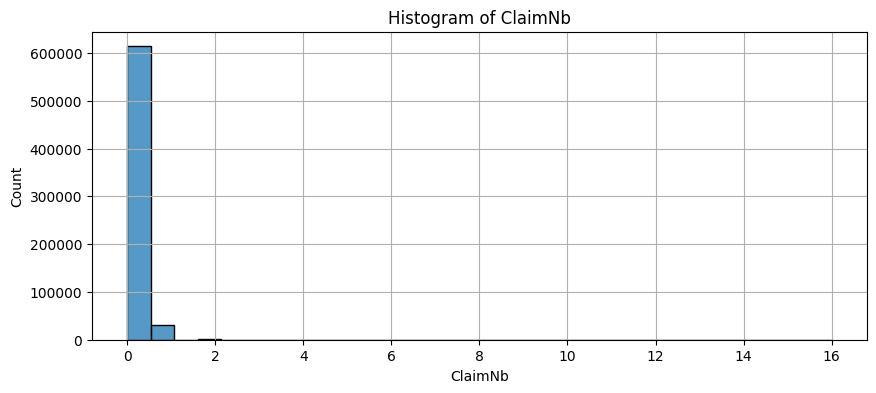

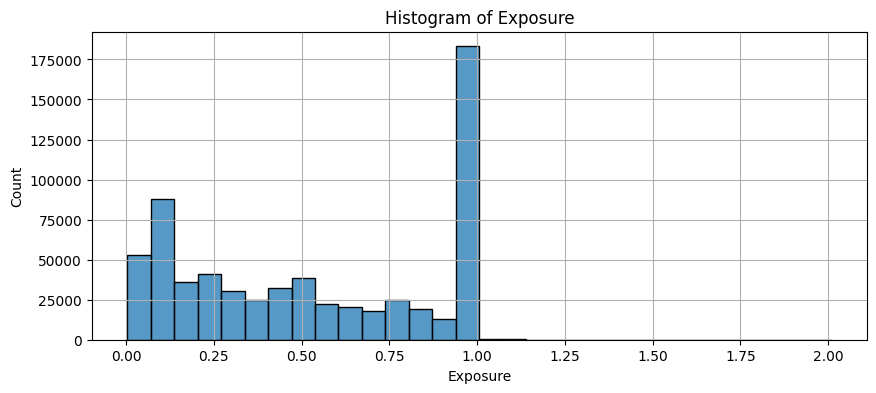

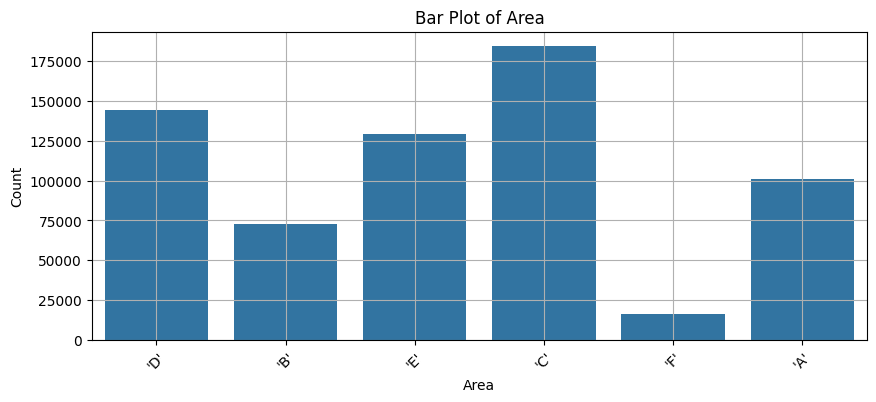

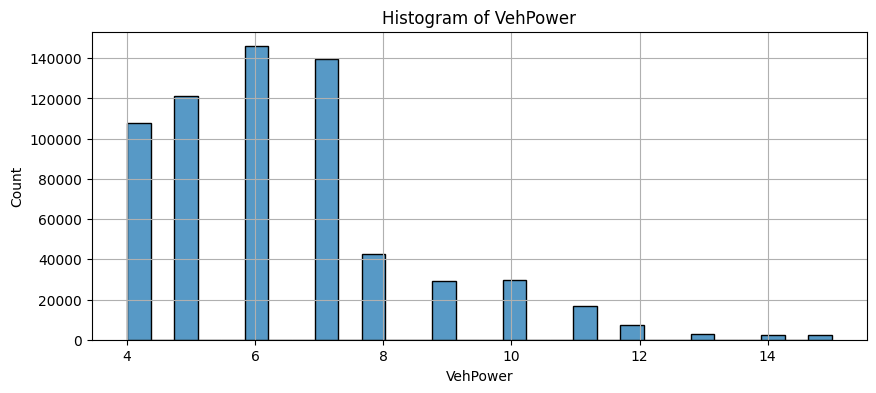

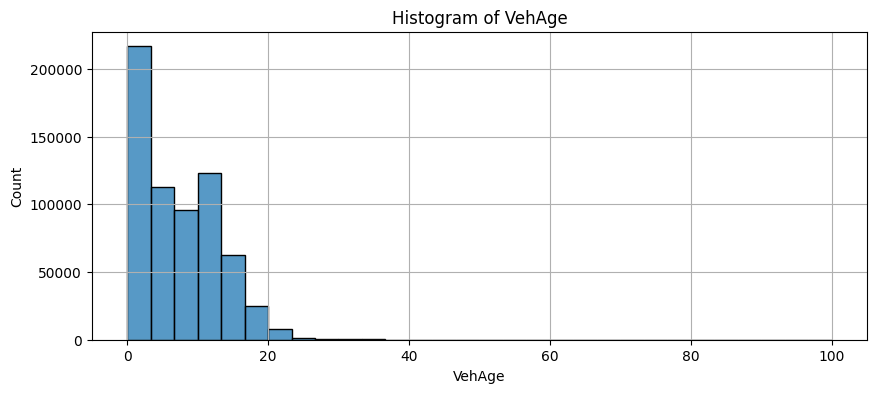

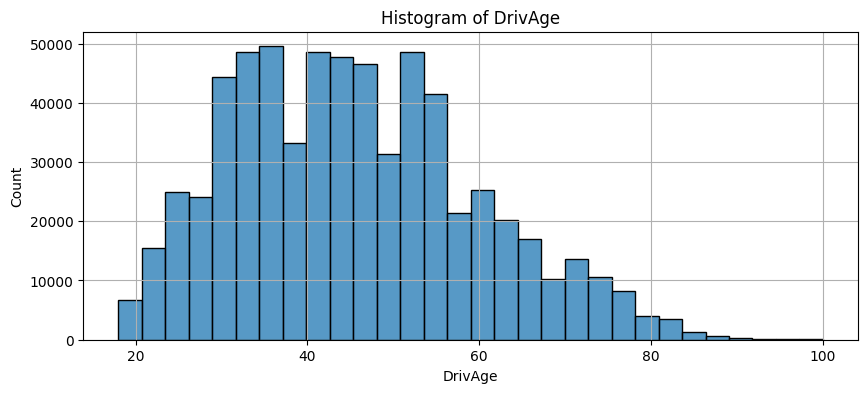

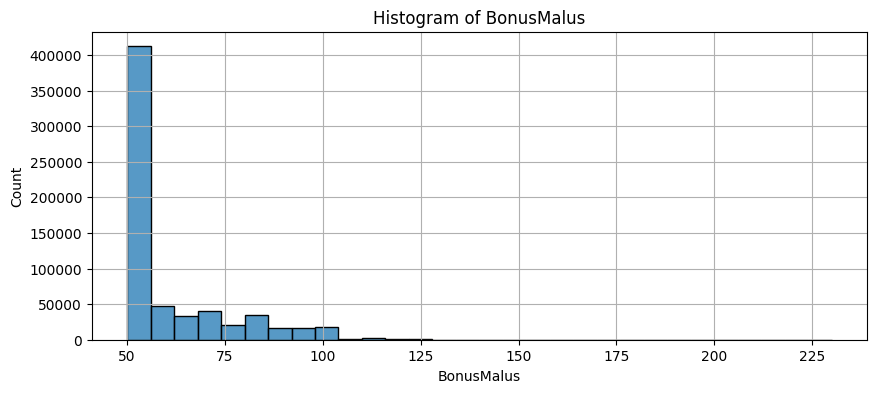

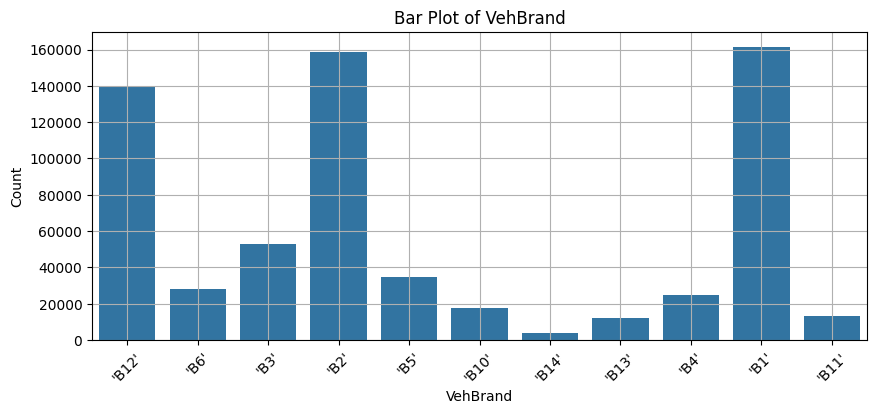

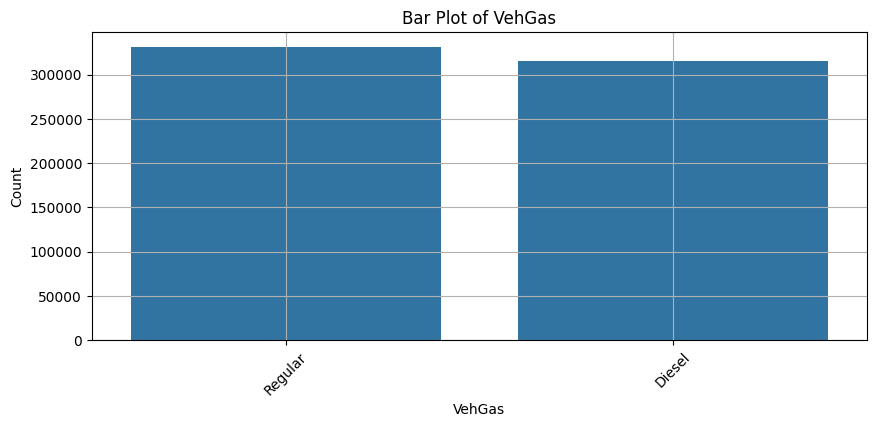

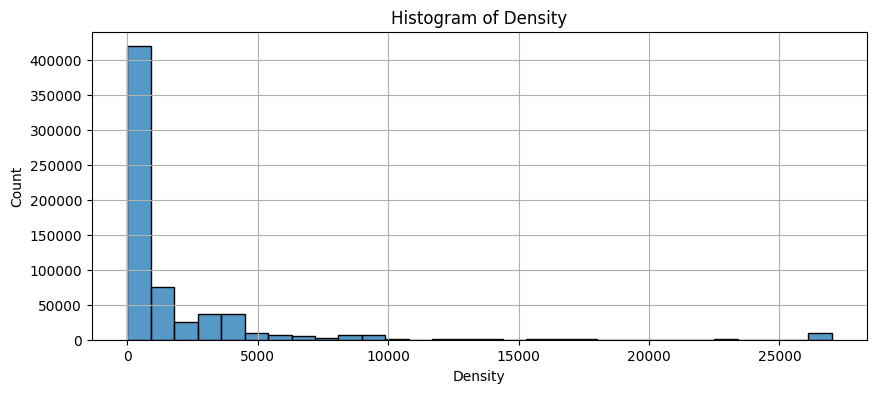

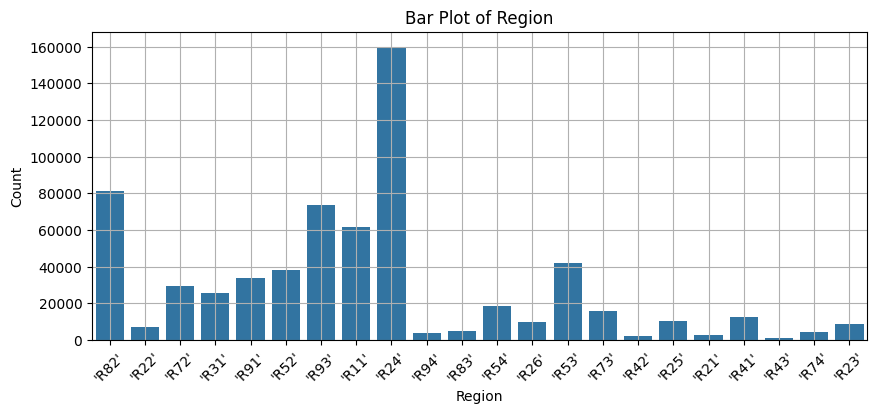

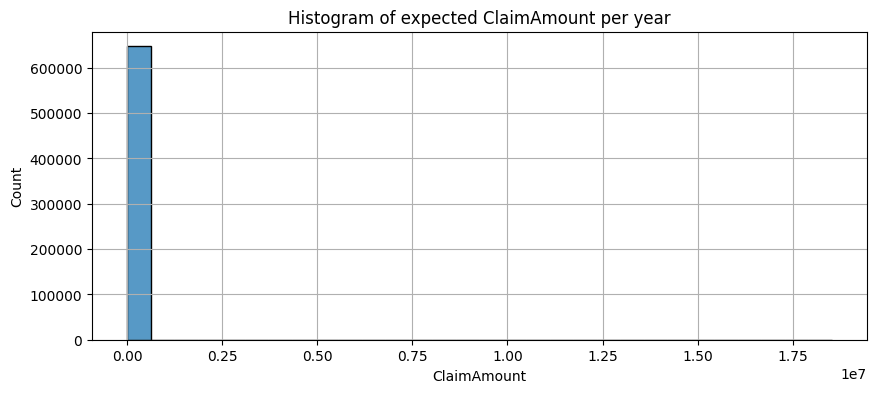

In [ ]:
categorical_columns = ['Area', 'VehBrand', 'VehGas', 'Region']
numerical_columns = [col for col in df_freq.columns if col not in categorical_columns]
def plot_data_distribution(df):
    for column in df.columns:
        plt.figure(figsize=(10, 4))  # Set figure size

        # Check if the column is categorical
        if column in categorical_columns:
            # Bar plot for categorical data
            sns.countplot(data=df, x=column)
            plt.title(f'Bar Plot of {column}')
            plt.xticks(rotation=45)  # Rotate x labels for better visibility if needed
        else:
            # Histogram for numerical data
            if column!= "ClaimAmount":
              sns.histplot(data=df, x=column, kde=False, bins=30)  # KDE for smooth distribution curve
              plt.title(f'Histogram of {column}')
            elif column== "ClaimAmount":
              sns.histplot(data=df[column]/df['Exposure'], kde=False, bins=30)
              plt.title(f'Histogram of expected {column} per year')


        plt.ylabel('Count')
        plt.xlabel(column)
        plt.grid(True)
        plt.show()


if feature_visualization:
    plot_data_distribution(merged_df)


*   Verwendung der 5-fachen Kreuzvalidierung zur Bewertung der Modellleistung

*   Metrik:
1.   MAE
2.   RMSE (mittlerer quadratischer Fehler)  
3.   D square
4.   R square




In [ ]:
# Prepare data for cross-validation
kf = KFold(n_splits=K_fold_splits, shuffle=True, random_state=random_seed)

# Metrics for evaluation
metrics = {
    'D_square': lambda y_true, y_pred: 1 - mean_squared_error(y_true, y_pred) / np.var(y_true),
    'R_square': r2_score,  # 1 - mean_squared_error(y_true, y_pred) / mean_squared_error(y_true, y_true.mean())
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
}

### Datenvorverarbeitung
* MinMax-Skalierung von kontinuierlichen Eingaben in das Werteintervall [0,1].   
* One-Hot-Codierung kategorischer Eingaben in das Werteintervall [0,1].
* Weglassen der Merkmale 'ClaimAmount', 'Exposure', 'ClaimNb' ('IDpol' wurde bereits früher weggelassen.)
* Das Regressionsziel wird ebenfalls in [0,1] skaliert, um die Stabilität des Trainings zu gewährleisten, da neuronale Netze in diesem Bereich in der Regel eine bessere Leistung erzielen.


Hinweis: Jetzt hat jede Merkmalsdimension den gleichen Wertebereich zwischen [0,1], so dass die Merkmalsrelevanz fair verglichen werden kann.






In [ ]:
feature_transformer = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), [col for col in merged_df.columns if
                             merged_df[col].dtype in [np.float64, np.float32] and col not in ['ClaimAmount', 'Exposure', 'IDpol', 'ClaimNb']]),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
     [col for col in merged_df.columns if merged_df[col].dtype == 'object'])
], remainder='passthrough')

feature_transformer.fit_transform(merged_df.drop(['ClaimAmount', 'Exposure', 'ClaimNb'], axis=1))
feature_names = feature_transformer.get_feature_names_out()
print("New Feature Names:", feature_names)

device = "cuda" if torch.cuda.is_available() else "cpu"
if include_sampling_weights:
    weights = torch.tensor(np.array(merged_df["Exposure"]), dtype=torch.float32, device=device)
else:
    weights = torch.tensor(np.ones(merged_df["Exposure"].shape), dtype=torch.float32, device=device)

New Feature Names: ['num__VehPower' 'num__VehAge' 'num__DrivAge' 'num__BonusMalus'
 'num__Density' "cat__Area_'A'" "cat__Area_'B'" "cat__Area_'C'"
 "cat__Area_'D'" "cat__Area_'E'" "cat__Area_'F'" "cat__VehBrand_'B1'"
 "cat__VehBrand_'B10'" "cat__VehBrand_'B11'" "cat__VehBrand_'B12'"
 "cat__VehBrand_'B13'" "cat__VehBrand_'B14'" "cat__VehBrand_'B2'"
 "cat__VehBrand_'B3'" "cat__VehBrand_'B4'" "cat__VehBrand_'B5'"
 "cat__VehBrand_'B6'" 'cat__VehGas_Diesel' 'cat__VehGas_Regular'
 "cat__Region_'R11'" "cat__Region_'R21'" "cat__Region_'R22'"
 "cat__Region_'R23'" "cat__Region_'R24'" "cat__Region_'R25'"
 "cat__Region_'R26'" "cat__Region_'R31'" "cat__Region_'R41'"
 "cat__Region_'R42'" "cat__Region_'R43'" "cat__Region_'R52'"
 "cat__Region_'R53'" "cat__Region_'R54'" "cat__Region_'R72'"
 "cat__Region_'R73'" "cat__Region_'R74'" "cat__Region_'R82'"
 "cat__Region_'R83'" "cat__Region_'R91'" "cat__Region_'R93'"
 "cat__Region_'R94'"]


### Definieren eines neuronalem Netz

Da das Regressionsziel viele Nullen hat, d.h. null-inflationiert ist, kann die Tweedie-Verteilung zur Modellierung der Ausgabe in diesem Fall gut verwendet werden. Sie wird auch häufig zur Modellierung der Risikopreise im Versicherungswesen verwendet.

Das `CustomNetwork` nimmt die kodierten Merkmale als Eingabe (Batch, # Merkmal=46) und gibt den \mu-Paramerer aus.

---
As good rainign practice using NNs:
*   Dropout-layers werden hinzugefügt, um overfitting zu verhindern, d.h. eine Regularisierung des Modells.
*    BatchNorm-layers werden hinzugefügt, um interne Kovariatenverschiebungen zu vermeiden und so die Konvergenz und Leistung zu verbessern.





In [ ]:
class CustomNetwork(nn.Module):
    def __init__(self, layer_sizes=(46, 128, 128, 128, 1)):
        super(CustomNetwork, self).__init__()

        # Ensure the layer_sizes is a tuple or list
        assert isinstance(layer_sizes, (tuple, list)), "layer_sizes must be a tuple or a list"
        assert len(layer_sizes) > 2, "layer_sizes must include input, at least one hidden layer, and output dimensions"

        # Create a list to hold layers
        layers = []

        # Iterate over the list of sizes to create the layers
        for i in range(len(layer_sizes) - 1):
            # Append the linear layer based on current and next layer sizes
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

            # Append BatchNorm layer except for the output layer
            if i < len(layer_sizes) - 2:
                layers.append(nn.BatchNorm1d(layer_sizes[i + 1]))
                # layers.append(nn.PReLU())
                layers.append(nn.GELU())
                layers.append(nn.Dropout(p=0.5))

        # Convert the list of layers into nn.Sequential
        if tweedie_loss:
            layers.append(nn.Softplus())

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential layers
        x = self.layers(x)
        return x

**Main loop for training with 5-fold cross validation**

* Die Verlustfunktion ist die Tweedie-Verlustfunktion, p wird auf $1.6$ gesetzt.

* The Tweedie distribution has the following PDF (for $1 <p< 2$): $f(y ; \mu, \phi, p)=a(y ; \phi) \exp \left[\frac{1}{\phi}\left\{y \frac{\mu^{1-p}}{1-p}-\frac{\mu^{2-p}}{2-p}\right\}\right]$ , where $a(y ; \phi)=\frac{1}{y} \sum_{j=1}^{\infty} \frac{y^{-j \alpha}(p-1)^{\alpha j}}{\phi^{j(1-\alpha)}(2-p)^j j!\Gamma(-j \alpha)}, \quad \alpha=\frac{2-p}{1-p}$.

* The Tweedie loss function is defeined as:

$$\begin{aligned} L L(\theta) & =\sum_{i=1}^N \log f_Y(y \mid \theta, \phi) \\ & \propto \sum_{i=1}^N\left(y_i \frac{\mu_i^{1-\rho}}{1-\rho}-\frac{\mu_i^{2-\rho}}{2-\rho}\right)\end{aligned}$$

---
Training Specifics:

* Jede Stichprobe wird nach der Exposition gewichtet. Eine hohe Belastung bedeutet eine hohe Gewichtung dieser Probe.

* Frühzeitige Abbruchkriterien werden angewendet, wenn sich die Validierungsleistung in den folgenden 30 Epochen nicht verbessert.

* Optimierer: Adam, lr =0,001, Zeitplan für das Abklingen der Lernrate aktiviert.


* Für jede Faltung werden die verschiedenen Bewertungsmetriken aufgezeichnet.

* Für die Modellbewertung wird der Mittelwert der oben genannten Metrik (MAE/RMSE...) aus jedem Fold als endgültige Leistungsmetrik für das Modell verwendet.

Epoch [1/500], Loss: 0.8314, Val Loss: 1.0450, LR: 0.000995
Epoch [2/500], Loss: 0.5874, Val Loss: 0.7919, LR: 0.000990
Epoch [3/500], Loss: 0.6315, Val Loss: 0.7576, LR: 0.000985
Epoch [4/500], Loss: 0.5677, Val Loss: 0.6722, LR: 0.000980
Epoch [5/500], Loss: 0.5023, Val Loss: 0.5662, LR: 0.000975
Epoch [6/500], Loss: 0.4634, Val Loss: 0.5149, LR: 0.000970
Epoch [7/500], Loss: 0.4603, Val Loss: 0.5075, LR: 0.000966
Epoch [8/500], Loss: 0.5359, Val Loss: 0.4993, LR: 0.000961
Epoch [9/500], Loss: 0.4288, Val Loss: 0.4739, LR: 0.000956
Epoch [10/500], Loss: 0.5012, Val Loss: 0.4986, LR: 0.000951
Epoch [11/500], Loss: 0.4965, Val Loss: 0.5512, LR: 0.000946
Epoch [12/500], Loss: 0.4580, Val Loss: 0.4851, LR: 0.000942
Epoch [13/500], Loss: 0.4601, Val Loss: 0.4719, LR: 0.000937
Epoch [14/500], Loss: 0.4225, Val Loss: 0.4541, LR: 0.000932
Epoch [15/500], Loss: 0.4133, Val Loss: 0.4483, LR: 0.000928
Epoch [16/500], Loss: 0.4713, Val Loss: 0.4931, LR: 0.000923
Epoch [17/500], Loss: 0.4540, Val

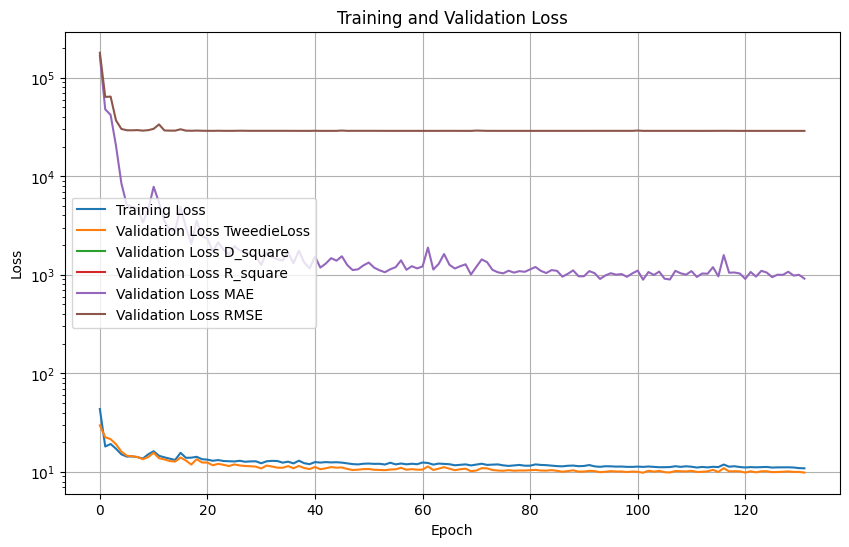

K_fold_iter 1
Epoch [1/500], Loss: 0.7795, Val Loss: 1.0066, LR: 0.000995
Epoch [2/500], Loss: 0.7314, Val Loss: 0.9500, LR: 0.000990
Epoch [3/500], Loss: 0.6157, Val Loss: 0.9149, LR: 0.000985
Epoch [4/500], Loss: 0.8513, Val Loss: 0.6579, LR: 0.000980
Epoch [5/500], Loss: 0.4799, Val Loss: 0.5864, LR: 0.000975
Epoch [6/500], Loss: 0.4808, Val Loss: 0.6047, LR: 0.000970
Epoch [7/500], Loss: 0.4702, Val Loss: 0.5656, LR: 0.000966
Epoch [8/500], Loss: 0.4557, Val Loss: 0.5813, LR: 0.000961
Epoch [9/500], Loss: 0.5027, Val Loss: 0.6337, LR: 0.000956
Epoch [10/500], Loss: 0.5170, Val Loss: 0.5498, LR: 0.000951
Epoch [11/500], Loss: 0.5135, Val Loss: 0.5581, LR: 0.000946
Epoch [12/500], Loss: 0.6470, Val Loss: 0.7371, LR: 0.000942
Epoch [13/500], Loss: 0.5689, Val Loss: 0.7172, LR: 0.000937
Epoch [14/500], Loss: 0.5192, Val Loss: 0.6402, LR: 0.000932
Epoch [15/500], Loss: 0.4909, Val Loss: 0.5858, LR: 0.000928
Epoch [16/500], Loss: 0.4830, Val Loss: 0.5487, LR: 0.000923
Epoch [17/500], Los

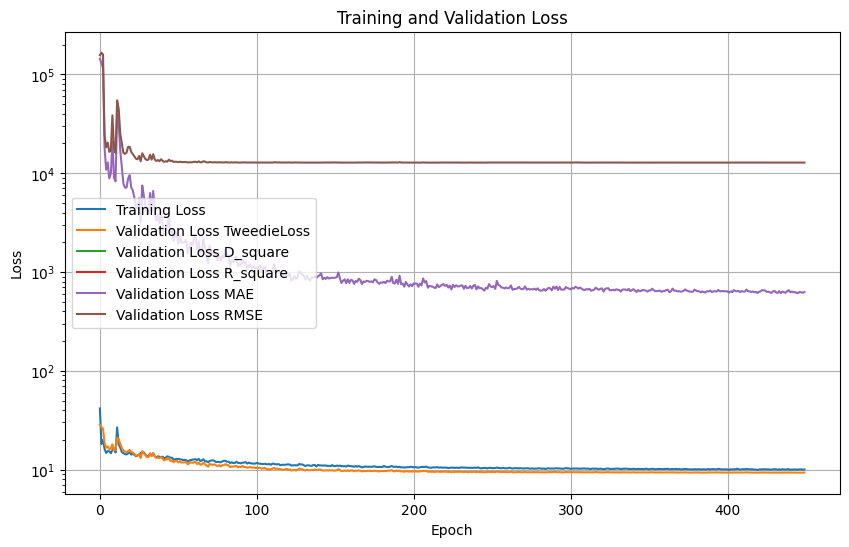

K_fold_iter 2
Epoch [1/500], Loss: 0.8345, Val Loss: 1.0478, LR: 0.000995
Epoch [2/500], Loss: 0.6824, Val Loss: 0.6990, LR: 0.000990
Epoch [3/500], Loss: 0.5527, Val Loss: 0.7688, LR: 0.000985
Epoch [4/500], Loss: 0.5401, Val Loss: 0.6919, LR: 0.000980
Epoch [5/500], Loss: 0.4983, Val Loss: 0.6452, LR: 0.000975
Epoch [6/500], Loss: 0.6527, Val Loss: 0.5969, LR: 0.000970
Epoch [7/500], Loss: 0.5017, Val Loss: 0.5537, LR: 0.000966
Epoch [8/500], Loss: 0.4602, Val Loss: 0.5440, LR: 0.000961
Epoch [9/500], Loss: 0.5248, Val Loss: 0.6520, LR: 0.000956
Epoch [10/500], Loss: 0.4833, Val Loss: 0.5655, LR: 0.000951
Epoch [11/500], Loss: 0.5441, Val Loss: 0.6329, LR: 0.000946
Epoch [12/500], Loss: 0.5194, Val Loss: 0.5669, LR: 0.000942
Epoch [13/500], Loss: 0.5219, Val Loss: 0.5165, LR: 0.000937
Epoch [14/500], Loss: 0.4757, Val Loss: 0.5220, LR: 0.000932
Epoch [15/500], Loss: 0.4825, Val Loss: 0.4839, LR: 0.000928
Epoch [16/500], Loss: 0.5051, Val Loss: 0.5643, LR: 0.000923
Epoch [17/500], Los

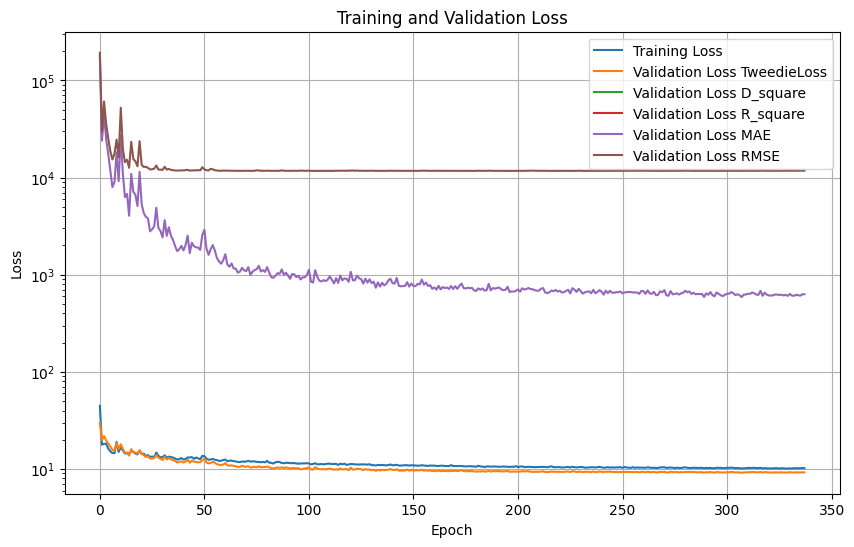

K_fold_iter 3
Epoch [1/500], Loss: 0.8832, Val Loss: 1.0706, LR: 0.000995
Epoch [2/500], Loss: 0.4865, Val Loss: 0.5453, LR: 0.000990
Epoch [3/500], Loss: 0.4613, Val Loss: 0.5049, LR: 0.000985
Epoch [4/500], Loss: 0.4649, Val Loss: 0.4973, LR: 0.000980
Epoch [5/500], Loss: 0.4734, Val Loss: 0.5269, LR: 0.000975
Epoch [6/500], Loss: 0.4305, Val Loss: 0.4764, LR: 0.000970
Epoch [7/500], Loss: 0.5671, Val Loss: 0.5003, LR: 0.000966
Epoch [8/500], Loss: 0.6080, Val Loss: 0.4810, LR: 0.000961
Epoch [9/500], Loss: 0.4486, Val Loss: 0.4574, LR: 0.000956
Epoch [10/500], Loss: 0.4537, Val Loss: 0.4850, LR: 0.000951
Epoch [11/500], Loss: 0.6565, Val Loss: 0.4400, LR: 0.000946
Epoch [12/500], Loss: 0.4636, Val Loss: 0.4270, LR: 0.000942
Epoch [13/500], Loss: 0.4101, Val Loss: 0.4290, LR: 0.000937
Epoch [14/500], Loss: 0.4717, Val Loss: 0.4203, LR: 0.000932
Epoch [15/500], Loss: 0.4400, Val Loss: 0.4383, LR: 0.000928
Epoch [16/500], Loss: 0.4375, Val Loss: 0.4240, LR: 0.000923
Epoch [17/500], Los

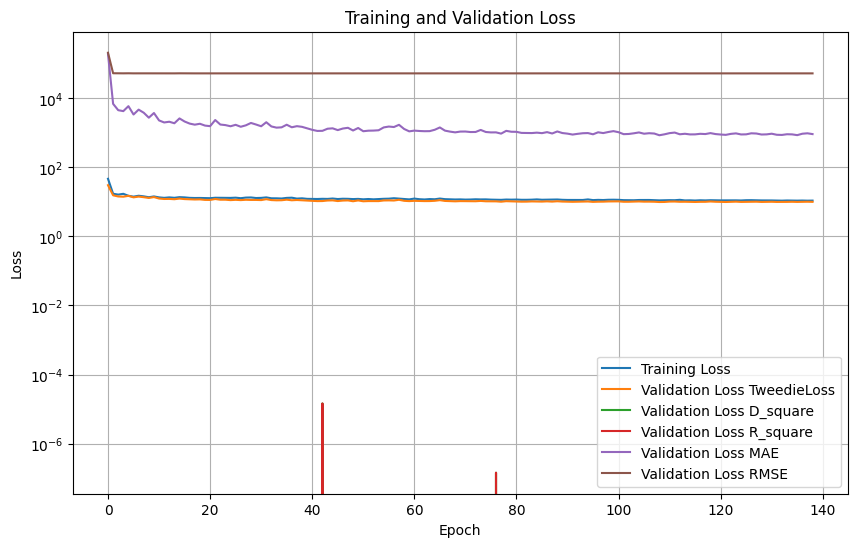

K_fold_iter 4
Epoch [1/500], Loss: 0.8426, Val Loss: 1.0499, LR: 0.000995
Epoch [2/500], Loss: 0.5842, Val Loss: 0.8159, LR: 0.000990
Epoch [3/500], Loss: 0.5215, Val Loss: 0.6664, LR: 0.000985
Epoch [4/500], Loss: 0.5375, Val Loss: 0.5556, LR: 0.000980
Epoch [5/500], Loss: 0.5085, Val Loss: 0.6244, LR: 0.000975
Epoch [6/500], Loss: 0.5264, Val Loss: 0.6199, LR: 0.000970
Epoch [7/500], Loss: 0.4724, Val Loss: 0.5527, LR: 0.000966
Epoch [8/500], Loss: 0.4825, Val Loss: 0.5158, LR: 0.000961
Epoch [9/500], Loss: 0.8401, Val Loss: 0.4779, LR: 0.000956
Epoch [10/500], Loss: 0.4717, Val Loss: 0.4950, LR: 0.000951
Epoch [11/500], Loss: 0.4413, Val Loss: 0.4910, LR: 0.000946
Epoch [12/500], Loss: 0.4315, Val Loss: 0.4646, LR: 0.000942
Epoch [13/500], Loss: 0.4307, Val Loss: 0.4865, LR: 0.000937
Epoch [14/500], Loss: 0.4668, Val Loss: 0.4610, LR: 0.000932
Epoch [15/500], Loss: 0.5610, Val Loss: 0.4504, LR: 0.000928
Epoch [16/500], Loss: 0.4623, Val Loss: 0.4828, LR: 0.000923
Epoch [17/500], Los

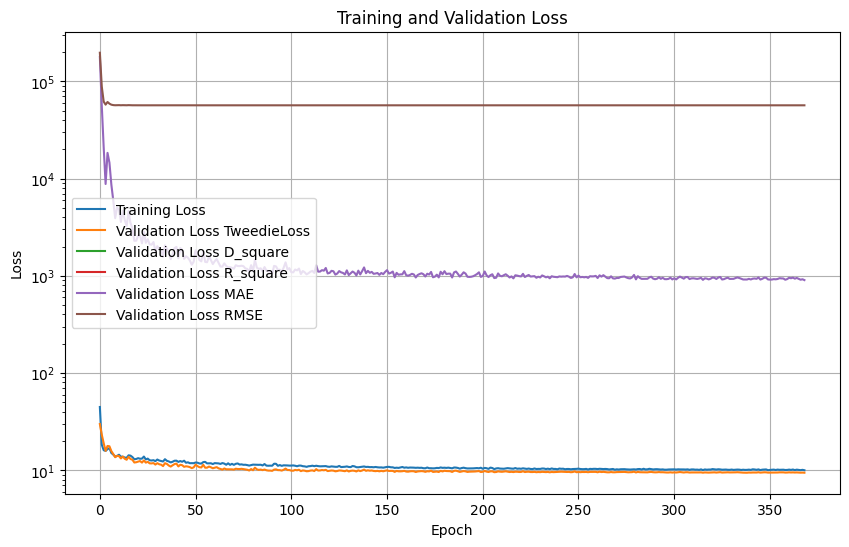

K_fold_iter 5


In [ ]:
results = {key: np.empty((K_fold_splits, num_epochs)) * np.nan for key in metrics.keys()}

k_fold_iter = 0
for train_index, test_index in kf.split(merged_df):
    train_df, test_df = merged_df.iloc[train_index], merged_df.iloc[test_index]
    X_train, y_train = feature_transformer.fit_transform(train_df.drop(['ClaimAmount', 'Exposure', 'ClaimNb'], axis=1)), train_df['ClaimAmount']/train_df['Exposure']
    X_test, y_test = feature_transformer.transform(test_df.drop(['ClaimAmount', 'Exposure'], axis=1)), test_df['ClaimAmount']/test_df['Exposure']

    if output_standardization:
        output_scaler = MinMaxScaler(feature_range=(0, 1))
        y_train = output_scaler.fit_transform(y_train.values.reshape(-1,1))
        y_test = output_scaler.transform(y_test.values.reshape(-1,1))
    y_train_min = y_train.min()
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

    # The implementation of only 2 weights.
    # weights_minor_class = len(train_df["ClaimAmount"]) / (2 * np.sum(train_df["ClaimAmount"] > 0))
    # weights_major_class = len(train_df["ClaimAmount"]) / (2 * np.sum(train_df["ClaimAmount"] == 0))
    # print("weights_for_class_imbalance", weights_minor_class, weights_major_class)

    # Train a model
    model = CustomNetwork(layer_sizes=(X_train.shape[1], 128, 128, 128, 1)).to(device)
    model_backup = CustomNetwork(layer_sizes=(X_train.shape[1], 128, 128, 128, 1)).to(device)
    model_backup.load_state_dict(model.state_dict())

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Define scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.995)
    if validation_criterion == "L1Loss":
        criterion = nn.L1Loss(reduction = 'none')
    elif validation_criterion == "MSELoss":
        criterion = nn.MSELoss(reduction='none')

    # ... include the training loop here ...
    # Lists to store losses for plotting
    train_losses, train_losses_unscaled = [] , []
    val_losses, val_losses_unscaled = [] , []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()

        batch_train = torch.randperm(X_train.shape[0])
        batch_train = batch_train[(batch_train.numel() % batch_size):]
        batch_train = batch_train.view(-1, batch_size)

        running_loss, running_loss_unscaled = 0, 0

        # for each mini-batch
        for i in range(batch_train.size(0)):

            optimizer.zero_grad()
            input = X_train[batch_train[i], :]
            target = y_train[batch_train[i]]
            predictions = model(input)
            if tweedie_loss:
                loss = -target * torch.pow(predictions, 1 - rho) / (1 - rho) + torch.pow(predictions, 2 - rho) / (2 - rho)
                loss_original_scale = -target.detach().cpu().numpy() * (1/output_scaler.scale_) * np.power(predictions.detach().cpu().numpy() * (1/output_scaler.scale_), 1 - rho) / (1 - rho) + np.power(predictions.detach().cpu().numpy() * (1/output_scaler.scale_), 2 - rho) / (2 - rho)
            else:
                loss = criterion(predictions, target)

            # Add weights to address class imbalance
            if include_sampling_weights:
                # weights = torch.where(target == y_train_min, weights_major_class, weights_minor_class)  # Increase the weight for non-zero targets
                loss = (loss * weights[batch_train[i]].unsqueeze(-1)).mean()  # Weighted loss
                loss_original_scale = (loss_original_scale * weights[batch_train[i]].unsqueeze(-1).detach().cpu().numpy()).mean()
            else:
                loss = loss.mean()
                loss_original_scale = loss_original_scale.mean()
            loss.backward()
            optimizer.step()
            # statistics
            running_loss += loss.item()
            running_loss_unscaled += loss_original_scale

        running_loss /= batch_train.size(0)
        running_loss_unscaled /= batch_train.size(0)

        if output_standardization and not tweedie_loss:
            train_losses.append(running_loss * 1 / output_scaler.scale_)  # Record training loss
        else:
            train_losses.append(running_loss)  # Record training loss
            train_losses_unscaled.append(np.squeeze(running_loss_unscaled))
        scheduler.step()  # Update learning rate


        # ----Validation----
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_test)
            if validation_criterion == 'MSELoss' or validation_criterion == 'L1Loss':
                val_loss = criterion(val_predictions, y_test)
            elif validation_criterion == 'TweedieLoss':
                val_loss = -y_test * torch.pow(val_predictions, 1 - rho) / (1 - rho) + torch.pow(val_predictions, 2 - rho) / (2 - rho)
                val_loss_original_scale = -y_test.detach().cpu().numpy() * (1 / output_scaler.scale_) * np.power(
                    val_predictions.detach().cpu().numpy() * (1 / output_scaler.scale_), 1 - rho) / (1 - rho) + np.power(
                    val_predictions.detach().cpu().numpy() * (1 / output_scaler.scale_), 2 - rho) / (2 - rho)

            if include_sampling_weights:
                val_loss = val_loss * weights[test_index].unsqueeze(-1)
                val_loss_original_scale = val_loss_original_scale * weights[test_index].unsqueeze(-1).detach().cpu().numpy()
            val_loss = val_loss.mean()
            val_loss_original_scale = val_loss_original_scale.mean()

        if output_standardization and not tweedie_loss:
            val_losses.append(val_loss.item() * 1 / output_scaler.scale_)
        else:
            val_losses.append(val_loss.item())
            val_losses_unscaled.append(val_loss_original_scale)
        current_lr = scheduler.get_last_lr()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, LR: {current_lr[0]:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            model_backup.load_state_dict(model.state_dict())
        else:
            epochs_no_improve += 1

        # Evaluation for different matrix
        val_predictions = val_predictions.cpu().numpy()
        y_test_np = y_test.detach().cpu().numpy()
        for name, metric_fn in metrics.items():
            results[name][k_fold_iter][epoch] = metric_fn(y_test_np * 1/output_scaler.scale_, val_predictions * 1/output_scaler.scale_)

        if epochs_no_improve == n_epochs_stop:
            print('Early stopping triggered')
            model.load_state_dict(model_backup.state_dict())
            del model_backup
            break

    if show_evaluation_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses_unscaled, label='Training Loss')
        plt.plot(val_losses_unscaled, label='Validation Loss ' + validation_criterion)
        for name, metric_fn in metrics.items():
            plt.plot(results[name][k_fold_iter], label='Validation Loss ' + name)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')
        plt.show()

    k_fold_iter += 1
    print('K_fold_iter', k_fold_iter)


## Visualisierung der Merkmalsbedeutung

*   Realisiert durch Backpropagation des Gradienten zu den Eingaben, gemittelt aus allen Trainingsproben durch die jeweiligen Probengewichte.
*   For categorical features, the gradients are computed as the mean absolute value of each one-hot encoded dimension.



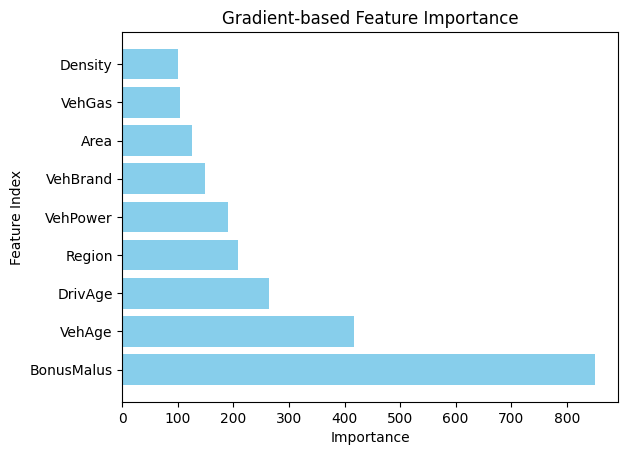

In [ ]:
def gradient_based_feature_importance(model, input_data, weights, feature_names, output_scaler):
    """
    Calculate gradient-based feature importance for a PyTorch model.

    Parameters:
    - model: A trained PyTorch model.
    - input_data: A batch of input data (torch.Tensor).

    Returns:
    - feature_importances: An array of feature importances.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Enable gradient calculation with respect to the input
    input_data.requires_grad = True

    # Perform a forward pass
    outputs = model(input_data)

    # Compute gradients
    outputs.backward(torch.ones_like(outputs))

    # Extract the gradients of the output with respect to inputs
    gradients = (input_data.grad.abs() * weights.unsqueeze(-1)).mean(dim=0)

    # Detach gradients and convert to numpy for further analysis/plotting
    feature_importances = gradients.detach().cpu().numpy()

    # Plot feature importance
    plt.figure()
    # plot all the features
    # plt.bar(range(len(feature_importances)), feature_importances, alpha=0.7)

    # Step to categorize and average gradients
    feature_groups = {}
    for name, grad in zip(feature_names, feature_importances):
        # Parse the feature name to find the base feature (before one-hot encoding)
        if '__' in name:
            base_name = name.split('__')[1].split('_')[0]
            if base_name not in feature_groups:
                feature_groups[base_name] = []
            feature_groups[base_name].append(grad)

    # Calculating the mean gradient for each original feature
    mean_gradients = {feature: np.mean(grads * 1 / output_scaler.scale_)  for feature, grads in feature_groups.items()}

    # Sorting for better visualization
    sorted_features = sorted(mean_gradients, key=mean_gradients.get, reverse=True)
    sorted_importances = [mean_gradients[feature] for feature in sorted_features]


    plt.barh(sorted_features, sorted_importances, color='skyblue')
    plt.ylabel('Feature Index')
    plt.xlabel('Importance')
    plt.title('Gradient-based Feature Importance')
    plt.show()

    return feature_importances

# Compute the importance
importance = gradient_based_feature_importance(model, X_train, weights[train_index], feature_names, output_scaler)


To Optimize:


*   Modellauswertung:  ordered Lorenz curve of the model. Berechnen des Gini-Koeffizienten : 1 -2 * AUC


Hyperparameter-Optimierung (mit Optuna)
* Modellarchitektur
* batch size, Optimierer, Lernrate.....
* Tweedie Verlustleistungsparameter p

Automatisches maschinelles Lernen: Auto-sklean (Mit allen Scikit-learn ML-Paketen, aber nicht direkt auf NNs.)


* Modellspezifische Hyperparameter: Auto-sklearn kann Hyperparameter optimieren, die für einzelne Modelle des maschinellen Lernens spezifisch sind, z. B. die Anzahl der Schätzer in einem Ensemble, die maximale Baumtiefe bei Entscheidungsbäumen, die Lernrate bei Gradient Boosting usw.
* Vorverarbeitungs-Hyperparameter: Es optimiert auch Vorverarbeitungs-Hyperparameter wie Merkmalskalierungsmethoden, Imputationsstrategien für fehlende Werte, Merkmalsauswahltechniken usw.

* Hyperparameter für Ensemble-Methoden: Auto-sklearn nutzt häufig Ensemble-Methoden, um Vorhersagen aus mehreren Modellen zu kombinieren. Es kann Hyperparameter im Zusammenhang mit Ensemble-Methoden optimieren, z. B. die Art des Ensembles (z. B. Random Forest, Gradient Boosting), die Anzahl der Modelle, die in das Ensemble aufgenommen werden sollen, und die Art der Gewichtung der Vorhersagen der einzelnen Modelle.